In [34]:
import numpy as np
import pandas as pd
import time
from collections import defaultdict
import seaborn as sns
import warnings
from IPython.display import clear_output
import os
import pickle as pkl
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

np.random.seed(1)

% matplotlib inline

# 03 - Probabilistic Latent Semantic Indexing

In the notebook, we explore the effectiveness of a technique called [Probablistic Latent Semantic Indexing](https://en.wikipedia.org/wiki/Probabilistic_latent_semantic_analysis) (PLSI), in which a binarized ratings matrix is factorized and reconstructed in order to predict ratings for hypothetical user-item pairs. Because the available data consists of explicit ratings ranging from 1 to 5, we binarize as follows:
- All ratings of 4 or above are mapped to 1 (positive rating)
- All other ratings are mapped to 0 (negative rating)

PLSI is commonly used to calculate conditional probabilities: given a user, what is the probability that a particular item has been positively rated? These conditional probabilities can be used to rank items for each user so that each user is presented with a list of $k$ items with the highest probability of being positively rated by the user. While this method has the advantage of displaying only those items a user is most likely to enjoy, previous tests (see Part 1 of this project) showed that catalog coverage is severely diminished with such an approach.

Instead, we use PLSI to calculate joint user-item probabilities instead, under the assumption that an alternate recommendation system is used in which the recommender displays a random selection of $k$ relevant items. Calculating joint probabilities also allows for a more direct comparison against the ground truth than calculating conditional probabilities allows.

Finally, in order to convert joint probabilities back to binarized predictions, we introduce a **threshold** hyperparameter: a joint probability is mapped to 1 if it is above the threshold and 0 otherwise. Because the optimal value for such a threshold depends on many factors, such as the noisiness of the data and the size of the dataset, an **optimize_threshold** method is introduced that performs a grid search for the best threshold, optimizing on **precision**. To prevent the method from returning an artificially high threshold to achieve a maximum precision of 1, we return the lowest threshold that achieves a target precision. Only in the event that the target precision cannot be achieved do we return the threshold corresponding to the highest possible precision.

In [3]:
class PLSI():
    
    def __init__(self, n_factors = 5, threshold = 0.5, optimize_threshold = False,
                 verbose = False, user = 'user', item = 'item', rating = 'rating'):
        self.n_items = 0
        self.n_users = 0
        self.n_latent_factors = n_factors
        self.n_iters = 0
        
        self.verbose = verbose
        self.threshold = threshold
        self.b_optimize_threshold = optimize_threshold
        
        self.user = user
        self.item = item
        self.rating = rating
        
        self.b_initialized = False
        
    def _make_bool_matrix(self):
        self.data.loc[:,self.rating] = self.data[self.rating].astype(bool)
        data_matrix = self.data.pivot_table(index=self.user, columns=self.item).fillna(False)
        return data_matrix
        
    def _train_initialize(self, data):
        
        self.data = data[data[self.rating] > 0]
        self.data_zero = data.copy()
        self.data_matrix = self._make_bool_matrix()
        print('num users:', self.data_matrix.shape[0])
        print('num items:', self.data_matrix.shape[1])
        
        print('proportion positive:', len(self.data) / len(self.data_zero))

        self.user_array = np.array(self.data_matrix.index)
        self.item_array = np.array(self.data_matrix.columns.levels[-1])
        
        self.n_users = len(self.user_array)
        self.n_items = len(self.item_array)
        self.n_impl_ratings = self.data[self.rating].sum()
        
        self.items_dict = defaultdict(list)
        for index, value in enumerate(self.item_array):
            self.items_dict[value] = index
            
        self.users_dict = defaultdict(list)
        for index, value in enumerate(self.user_array):
            self.users_dict[value] = index
            
        print('')
            
    def _param_initialize(self):
        self.prob_z_given_user = np.random.rand(self.n_users, self.n_latent_factors)
        self.prob_item_given_z = np.random.rand(self.n_latent_factors, self.n_items)
        self.prob_z_given_user_item = np.random.rand(self.n_latent_factors)
        
        user_group = self.data.groupby(self.user)
        self.count_user = user_group[self.rating].sum()
        self.prob_user = self.count_user / self.n_impl_ratings
        
        item_group = self.data.groupby(self.item)
        self.count_item = item_group[self.rating].sum()
    
    def _update_params(self):
        
        self.prob_item_given_user = np.dot(self.prob_z_given_user, self.prob_item_given_z)
        
        for z in range(self.n_latent_factors):
            #print('\n===========Z={}==========='.format(z))
            
            #print('\n=======E-step=======')
            
            prob_z_given_user_item = np.dot(self.prob_z_given_user[:,z].reshape(1, -1).T,\
                                            self.prob_item_given_z[z,:].reshape(1, -1)) / \
                                            self.prob_item_given_user
            
            data_matrix_z = self.data_matrix * prob_z_given_user_item
            
            #print('\n=======LOOP 1=======')
            prob_z_given_user_num_array = data_matrix_z.sum(axis = 1)
            prob_z_given_user_den_array = self.data_matrix.sum(axis = 1)
            
            prob_z_given_user_array = prob_z_given_user_num_array.values / prob_z_given_user_den_array
            self.prob_z_given_user[:,z] = prob_z_given_user_array
            
            #print('\n=======LOOP 2=======')
            prob_item_given_z_den = data_matrix_z.sum().sum()
            prob_item_given_z_num_array = data_matrix_z.sum(axis = 0)
            prob_item_given_z_array = prob_item_given_z_num_array / prob_item_given_z_den
            self.prob_item_given_z[z, :] = prob_item_given_z_array
            #clear_output()

    def _calc_log_likelihood(self):

        summand_1 = (self.data_matrix * np.log(self.prob_item_given_user)).sum().sum()
        prob_user_array = (self.data_matrix.sum(axis = 1) / self.data_matrix.sum().sum()).values
        count_user_array = self.data_matrix.sum(axis = 1)
        
        summand_2 = (count_user_array * np.log(prob_user_array)).sum()
        log_likelihood = summand_1 + summand_2
        
        return log_likelihood
    
    def _calc_reconstruction(self):
        
        total_instances = self.data_matrix.sum().sum()
        
        prob_user_array = (self.data_matrix.sum(axis = 1) / self.data_matrix.sum().sum()).values.reshape(1, -1).T
        self.prob_joint_user_item = self.prob_item_given_user * prob_user_array * total_instances
        return self.prob_joint_user_item
    
    def _train_predict(self):
        
        self._calc_reconstruction()
        pred_list = list()
        for row_index in range(len(self.data_zero)):
            row = self.data_zero.iloc[row_index, :]
            user = row[self.user]
            item = row[self.item]
            rating = row[self.rating]
            
            item_index = self.items_dict[item]
            user_index = self.users_dict[user]
            
            if isinstance(item_index, list) or isinstance(user_index, list):
                rating_pred = 0
            else:
                rating_pred = self.prob_joint_user_item[user_index][item_index]
            pred_list.append(rating_pred)
            
        pred_array = np.array(pred_list)
        ratings_array = np.array(self.data_zero[self.rating])
        
        return pred_array, ratings_array
    
    def display_metrics(self, data = None):
        if not isinstance(data, pd.DataFrame):
            print('===TRAINING METRICS===')
            pred_array, ratings_array = self._train_predict()
        else:
            print('===TEST/DEV METRICS===')
            ratings_array = np.array(data[self.rating])
            pred_array = self.predict_proba(data)
        
        mae = np.abs(ratings_array - pred_array).mean()
        auc = roc_auc_score(ratings_array, pred_array)

        print('mae:', mae)
        print('roc-auc:', auc)
        return (mae, auc)
    
    def optimize_threshold(self, data, upper = 0.5, steps = 100, target_precision = 0.9):
        print('\n=========optimizing threshold=========')
        ratings_array = data[self.rating]
        pred_array = self.predict_proba(data)
        threshold_array = np.linspace(0, upper, steps)[1:]
        
        best_threshold = 0
        best_precision = 0
        for threshold in threshold_array:
            precision = sum((pred_array >= threshold) & (ratings_array == 1)) / sum(pred_array >= threshold)
            recall = sum((pred_array >= threshold) & (ratings_array == 1)) / sum(ratings_array)
            f1_score = (2 * precision * recall) / (precision + recall)
            if precision > best_precision:
                best_precision = precision
                best_threshold = threshold
            if precision > target_precision:
                break
                             
        self.threshold = best_threshold
        print('optimal threshold:', best_threshold)
        print('optimal precision:', best_precision)
        
    def fit(self, data, n_iters):
        self.n_iters += n_iters
        if not self.b_initialized:
            self._train_initialize(data)
            self._param_initialize()
            self.b_initialized = True
        
        for i in range(n_iters):
            self._update_params()
        
            if self.verbose:
                print('\n==================ITER {}=================='.format(i+1))
                self.display_metrics()
                
                log_l = self._calc_log_likelihood()
                print('log-likelihood:', log_l)
                
        if self.b_optimize_threshold:
            self.optimize_threshold(data)
        if not self.verbose:
            self.display_metrics()
    
    def predict_proba(self, data):
        pred_list = list()
        self._calc_reconstruction()
        for row_index in range(len(data)):
            row = data.iloc[row_index, :]
            user = row[self.user]
            item = row[self.item]
            #rating = row[self.rating]
            
            item_index = self.items_dict[item]
            user_index = self.users_dict[user]
            
            if isinstance(item_index, list) or isinstance(user_index, list):
                rating_pred = 0
            else:
                rating_pred = self.prob_joint_user_item[user_index][item_index]
            pred_list.append(rating_pred)
            
        pred_array = np.array(pred_list)
        
        return pred_array
        
    def predict(self, data):
        pred_array = self.predict_proba(data)
        return pred_array >= self.threshold
    
    def display_parameters(self):
        print('===HYPERPARAMETERS===')
        print('n_factors:', self.n_latent_factors)
        print('n_iters:', self.n_iters)
        print('threshold:', self.threshold)

### Test 1 - A Small Simple Case
To test the correctness of the PLSI class and its methods, we fit the model on a simple $4 \times 4$ matrix that theoretically can be factorized using two latent factors. We see below that after 5 iterations, the threshold optimizer is able to find a threshold that results in optimal precision and the matrix reconstruction approximates the original matrix.

In [5]:
df_4_orig = pd.DataFrame([[1,1,0,0],
                    [1,1,0,0],
                    [0,0,1,1],
                    [0,0,1,1]], columns = list('abcd'), index=list('qrst'))
df_4 = df_4_orig.reset_index()
df_4 = df_4.melt(value_vars=list('abcd'), id_vars = 'index')
df_4.columns = ['user', 'item', 'rating']

plsi = PLSI(n_factors = 2, optimize_threshold = False)
plsi.fit(df_4, n_iters = 5)
print(plsi.prob_joint_user_item)

num users: 4
num items: 4
proportion positive: 0.5

===TRAINING METRICS===
mae: 0.378496199807
roc-auc: 0.9375
[[ 0.59132243  0.65529653  0.50656463  0.24681641]
 [ 0.58864788  0.65074837  0.50637237  0.25423138]
 [ 0.42441433  0.3714643   0.49456659  0.70955478]
 [ 0.39561536  0.32249081  0.4924964   0.78939743]]


After allowing the model to learn on 5 additional iterations, we see that the matrix reconstruction is significantly more accurate.

In [6]:
plsi.fit(df_4, n_iters=5)
print(plsi.prob_joint_user_item)
plsi.display_parameters()

===TRAINING METRICS===
mae: 2.04515021655e-08
roc-auc: 1.0
[[  9.99999980e-01   9.99999980e-01   3.63290326e-08   4.57397160e-09]
 [  9.99999980e-01   9.99999980e-01   3.63290326e-08   4.57397160e-09]
 [  2.27235909e-08   2.27235909e-08   9.99999961e-01   9.99999993e-01]
 [  1.81794133e-08   1.81794133e-08   9.99999966e-01   9.99999998e-01]]
===HYPERPARAMETERS===
n_factors: 2
n_iters: 10
threshold: 0.5


### Test 2 - A Small Messier Case
Below, we test a $5 \times 5$ matrix but with ratings assigned such that 3 latent factors will only be able to approximate the original matrix at best. After 5 iterations, the matrix reconstruction is far from precise, but adjusting the threshold yields good results. Notably, the default target threshold of 0.9 is achieved so threshold is not adjusted higher to achieve even greater precision.

In [7]:
np.random.seed(2)

df_5_orig = pd.DataFrame([[1,1,1,0,0],
                    [1,1,1,0,0],
                    [1,1,0,0,1],
                    [0,1,0,1,1],
                    [0,1,0,1,0]],
                    columns = list('abcde'), index = list('qrstu'))
df_5 = df_5_orig.reset_index()
df_5 = df_5.melt(value_vars=list('abcde'), id_vars = 'index')
df_5.columns = ['user', 'item', 'rating']

plsi = PLSI(n_factors = 3)
plsi.fit(df_5, n_iters = 5)
print(plsi.prob_joint_user_item)

num users: 5
num items: 5
proportion positive: 0.56

===TRAINING METRICS===
mae: 0.312426772125
roc-auc: 0.941558441558
[[ 0.58766227  1.20335202  0.63161555  0.43149723  0.14587293]
 [ 0.66084028  1.14234507  0.58011396  0.41432536  0.20237533]
 [ 0.72066667  0.89948189  0.16914909  0.42280958  0.78789276]
 [ 0.61907592  0.97317231  0.2196157   0.44793296  0.74020311]
 [ 0.41175486  0.7816487   0.3995057   0.28343488  0.12365586]]


After 5 extra iterations, the matrix reconstruction is improved, as are all performance metrics.

In [8]:
plsi.fit(df_5, n_iters=5)
print(plsi.prob_joint_user_item)
plsi.display_parameters()

===TRAINING METRICS===
mae: 0.171340027625
roc-auc: 0.987012987013
[[ 0.78281402  1.16592999  0.82331057  0.22105317  0.00689224]
 [ 0.82258964  1.14858856  0.77462103  0.20740817  0.0467926 ]
 [ 0.99590239  0.92485036  0.02313381  0.29992833  0.75618512]
 [ 0.05275323  1.01709267  0.01672304  0.9506033   0.96282777]
 [ 0.34594072  0.74353842  0.36221155  0.32100703  0.22730227]]
===HYPERPARAMETERS===
n_factors: 3
n_iters: 10
threshold: 0.5


# Tests on real data

In [9]:
# import data
data_path = os.path.join('..','data-2','splits')

with open(os.path.join(data_path, 'train.df'), 'rb') as file_in:
    train_df = pkl.load(file_in)
    
with open(os.path.join(data_path, 'dev.df'), 'rb') as file_in:
    cv_df = pkl.load(file_in)

with open(os.path.join(data_path, 'test.df'), 'rb') as file_in:
    test_df = pkl.load(file_in)    
    
# binarize ratings
train_df['rating'] = (train_df['rating'] >= 4).astype(bool)
cv_df['rating'] = (cv_df['rating'] >= 4).astype(bool)
test_df['rating'] = (test_df['rating'] >= 4).astype(bool)

# subset data
subset = ['user','item','rating']
train_df = train_df[subset]
cv_df = cv_df[subset]
test_df = test_df[subset]

In [11]:
use_pretrained = True

if use_pretrained:
#     plsi_train_df = pd.read_csv(os.path.join('..', 'data-2', 'results_plsi_train.csv'))
#     plsi_cv_df = pd.read_csv(os.path.join('..', 'data-2', 'results_plsi_cv.csv'))
#     plsi_test_df = pd.read_csv(os.path.join('..', 'data-2', 'results_plsi_test.csv'))
    
    with open(os.path.join('..', 'data-2', 'plsi_metrics.list'), 'rb') as file_in:
        plsi_metrics = pkl.load(file_out)
else:
    # objects for collecting results
    plsi_metrics = list()
    plsi_train_df = train_df.copy()
    plsi_cv_df = cv_df.copy()
    plsi_test_df = test_df.copy()

    # set hyperparameter options
    iterations_list = list(range(5, 35, 5))
    factors_list = list(range(5, 45, 5))
    
    # grid search
    for n_factors in factors_list:
        plsi = PLSI(n_factors = n_factors, optimize_threshold=False)
        for n_iterations in iterations_list:
            print('==========={} FACTORS - {} ITERATIONS==========='.format(n_factors, n_iterations))
            plsi.fit(train_df, n_iters = 5)
            plsi_metrics.append(plsi.display_metrics(cv_df))
            plsi.display_parameters()

            column_name = '{}f-{}i'.format(n_factors, n_iterations)
            plsi_train_df[column_name] = plsi.predict_proba(train_df)
            plsi_cv_df[column_name] = plsi.predict_proba(cv_df)
            plsi_test_df[column_name] = plsi.predict_proba(test_df)
    
    # save results
    plsi_train_df.to_csv(os.path.join('..', 'data-2', 'results_plsi_train.csv'), header=True, index=False)
    plsi_cv_df.to_csv(os.path.join('..', 'data-2', 'results_plsi_cv.csv'), header=True, index=False)
    plsi_test_df.to_csv(os.path.join('..', 'data-2', 'results_plsi_test.csv'), header=True, index=False)
    
    with open(os.path.join('..', 'data-2', 'plsi_metrics.list'), 'wb') as file_out:
        pkl.dump(plsi_metrics, file_out)

===========5 FACTORS - 5 ITERATIONS===========
num users: 7502
num items: 6765
proportion positive: 0.7106264005718405

===TRAINING METRICS===
mae: 0.69488763699
roc-auc: 0.612345152235
===TEST/DEV METRICS===
mae: 0.697255025884
roc-auc: 0.588318472055
===HYPERPARAMETERS===
n_factors: 5
n_iters: 5
threshold: 0.5
===========5 FACTORS - 10 ITERATIONS===========
===TRAINING METRICS===
mae: 0.693161476428
roc-auc: 0.626903991054
===TEST/DEV METRICS===
mae: 0.696216503889
roc-auc: 0.589197909503
===HYPERPARAMETERS===
n_factors: 5
n_iters: 10
threshold: 0.5
===========5 FACTORS - 15 ITERATIONS===========
===TRAINING METRICS===
mae: 0.688199599175
roc-auc: 0.630894313766
===TEST/DEV METRICS===
mae: 0.691542889835
roc-auc: 0.594335092661
===HYPERPARAMETERS===
n_factors: 5
n_iters: 15
threshold: 0.5
===========5 FACTORS - 20 ITERATIONS===========
===TRAINING METRICS===
mae: 0.685102334057
roc-auc: 0.627727453106
===TEST/DEV METRICS===
mae: 0.688186263125
roc-auc: 0.596177001714
===HYPERPARAMETE

===========30 FACTORS - 15 ITERATIONS===========
===TRAINING METRICS===
mae: 0.677907330304
roc-auc: 0.693563872599
===TEST/DEV METRICS===
mae: 0.686593363947
roc-auc: 0.595249295934
===HYPERPARAMETERS===
n_factors: 30
n_iters: 15
threshold: 0.5
===========30 FACTORS - 20 ITERATIONS===========
===TRAINING METRICS===
mae: 0.673064550362
roc-auc: 0.694181524266
===TEST/DEV METRICS===
mae: 0.68232152518
roc-auc: 0.598500320042
===HYPERPARAMETERS===
n_factors: 30
n_iters: 20
threshold: 0.5
===========30 FACTORS - 25 ITERATIONS===========
===TRAINING METRICS===
mae: 0.670593221908
roc-auc: 0.694211078047
===TEST/DEV METRICS===
mae: 0.680043142957
roc-auc: 0.599686410552
===HYPERPARAMETERS===
n_factors: 30
n_iters: 25
threshold: 0.5
===========30 FACTORS - 30 ITERATIONS===========
===TRAINING METRICS===
mae: 0.669136477585
roc-auc: 0.694592244927
===TEST/DEV METRICS===
mae: 0.678731773347
roc-auc: 0.600708119141
===HYPERPARAMETERS===
n_factors: 30
n_iters: 30
threshold: 0.5
===========35 FAC

In [28]:
n_factor_params = len(factors_list)
n_iter_params = len(iterations_list)

mae_matrix = np.array([x[0] for x in plsi_metrics]).reshape(n_factor_params, n_iter_params)
auc_matrix = np.array([x[1] for x in plsi_metrics]).reshape(n_factor_params, n_iter_params)

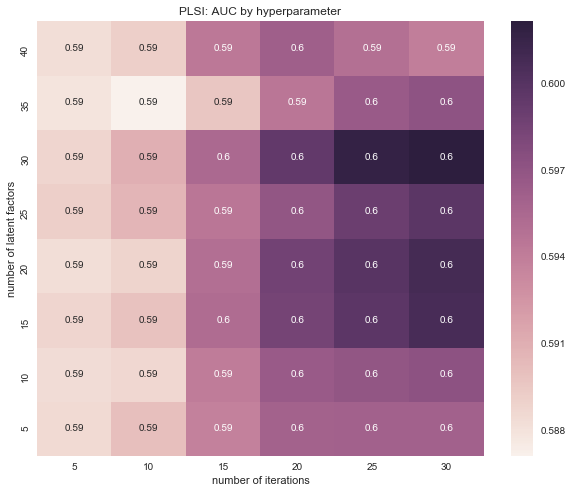

In [42]:
plt.figure(figsize = (10,8))
ax = sns.heatmap(auc_matrix, annot=True)
__ = ax.set(xticklabels = iterations_list, yticklabels = factors_list, title = 'PLSI: AUC by hyperparameter',
           xlabel = 'number of iterations', ylabel = 'number of latent factors')